<center><h1> Fitting a Single Frame.

Here we will extract a normalized hologram of a colloidal sphere from unnormalized experimental microscopy data then fit said hologram to, you guessed it, the Lorenz-Mie theory. Contact the Grier Group with any questions, suggestions, etc about using pylorenzmie, and we will be happy to help.

In [1]:
# The Usual Suspects.
import numpy as np 
import scipy as sp    
import pandas as pd   
import os
import cv2

In [2]:
# Hologram generation and fitting imports
from pylorenzmie.theory import LMHologram, Instrument
from pylorenzmie.theory.Feature import Feature
from lmfit import report_fit

In [3]:
# For circle transform detection
import pylorenzmie.detection.circletransform as ct
import pylorenzmie.detection.h5video as h5
import pylorenzmie.detection.localize as localize
import trackpy as tp

In [4]:
# For CNNLorenzMie detection
from CNNLorenzMie.Localizer import Localizer
from CNNLorenzMie.nodoubles import nodoubles

In [5]:
# For Plotting.
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', font_scale=2)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)

Populating the interactive namespace from numpy and matplotlib


## Extracting a normalized frame.
To normalize an image, we will need raw data, a background image, and the following formula $$\frac{I_{image} - dc}{I_{background} - dc},$$
where $I$ is measured intensity and $dc$ is your camera's dark count. We have measured our background image by using optical tweezers to drag the particles away from the viewing area.

In [6]:
# Read raw image and background image
fn = "sample.png"
fn_bg = "background.png"
image = cv2.imread(fn)
background = cv2.imread(fn_bg)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
background = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)

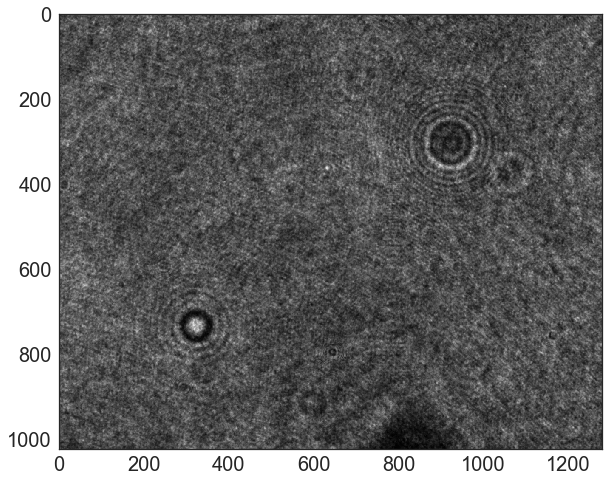

In [7]:
# Plot raw data
plt.imshow(image, cmap='gray')

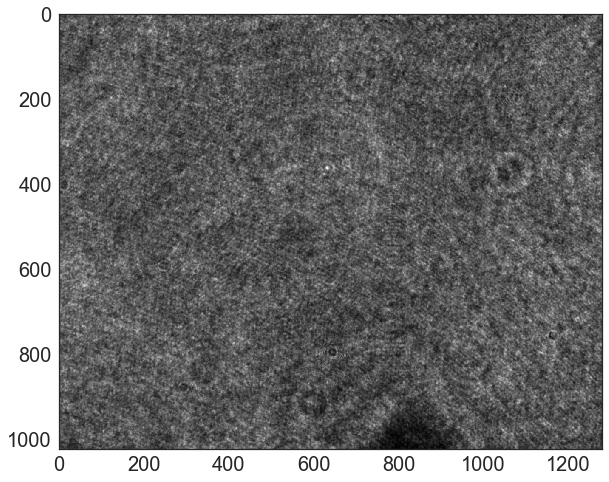

In [8]:
# Plot background data
plt.imshow(background, cmap='gray')

In [9]:
# Notice that cv2 reads images as type integer with mean pixel value ~100. Least-squares fitting demands a mean value ~1.
np.mean(image)

78.42362594604492

In [10]:
# Define the dark count of your camera
dark_count = 13

In [11]:
# Normalize your image
norm = (image - dark_count) / (background - dark_count)

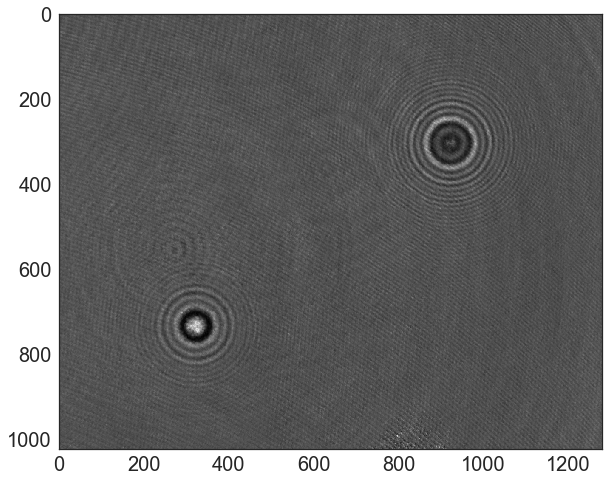

In [12]:
# Plot your nice-looking frame! 
plt.imshow(norm, cmap='gray')

In [13]:
# Make sure your normalized frame has a mean ~1! This is very important for least-squares fitting and other algorithms.
np.mean(norm)

1.0025262715520904

## Find the holographic features.
It can be a bit tricky to optimize detection using the circle transform method demonstrated here. The key is to play with the parameters in trackpy.locate to work with your specific feature. For more robust detection, we recommend using our deep convolutional neural network detection, found at https://github.com/laltman2/CNNLorenzMie.

Let's initialize our traditional detection method!

In [14]:
def detect(image, trackpy_params={'diameter': 30,
                                    'minmass': None,
                                    'topn': None,
                                    'engine': 'numba'}):
    '''
    Example wrapper that uses orientational alignment transform (OAT)
    and trackpy.locate to return features in an image.
    
    Scheme for using OAT method:
    1) Use circletransform.py to turn rings into blobs.
    2) Use trackpy.locate to locate these blobs.
    
    Keywords:
        trackpy_params: dictionary of keywords to feed into trackpy.locate.
                        See trackpy.locate's documentation to learn to use
                        these to optimize detection. These can be a bit tricky!
    Returns:
        features: matrix w/ columns ['xc', 'yc', 'w', 'h'] and rows as a 
                  detection. (xc, yc) is the center of the particle, and 
                  (w, h) = (201, 201) by default.
        circ: circle_transform of original image for plotting.
    '''
    circ = ct.circletransform(image, theory='orientTrans')
    circ = circ / np.amax(circ)
    circ = h5.TagArray(circ, frame_no=None)
    features = tp.locate(circ, **trackpy_params)
    features['w'] = 201
    features['h'] = 201
    features = np.array(features[['x', 'y', 'w', 'h']])
    return features, circ

Let's also initialize our CNNLorenzMie detection.

In [15]:
# Initialize Localizer
localizer = Localizer()

INFO:darknet:Loading network and metadata


/home/michael/python/CNNLorenzMie/cfg_darknet/holo.cfg /home/michael/python/CNNLorenzMie/cfg_darknet/holo.weights /home/michael/python/CNNLorenzMie/cfg_darknet/holo.data


In [16]:
# The localizer wants a three channel image
def inflate(image):
    '''
    Returns a RGB image from a BW image.
    '''
    shape = image.shape
    new_image = np.zeros([shape[0], shape[1], 3])
    new_image[:, :, 0] = image
    new_image[:, :, 1] = image
    new_image[:, :, 2] = image
    return new_image

Now let's demonstrate both methods. Here we will not do justice to the robustness of CNNLorenzMie's detection because we have already found trackpy.locate parameters that work for this frame. We stress that besides adjusting its confidence threshold, CNNLorenzMie's Localizer requires no tinkering for a successful detection!

In [17]:
# First find features using orientational alignment transform (OAT). 
trackpy_params = {'diameter': 51, 'minmass': 25.}
features, circle_transform = detect(norm, trackpy_params=trackpy_params)

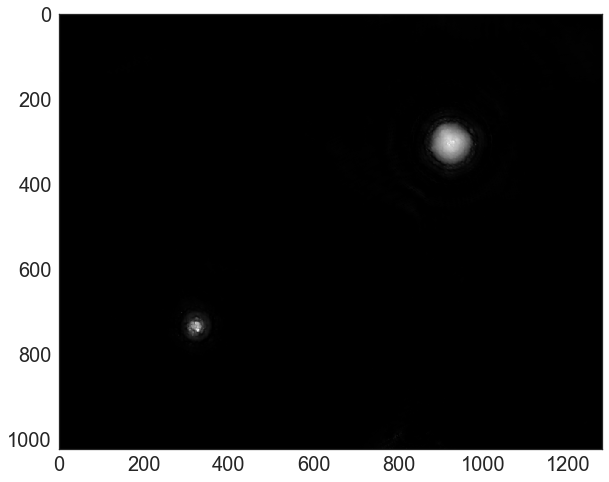

In [18]:
# Plot transformed image
if circle_transform is not None:
    plt.imshow(circle_transform, cmap='gray')

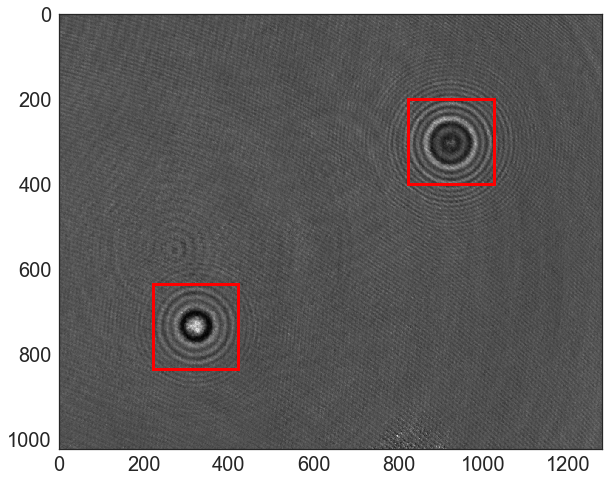

In [19]:
# Plot boxes onto image.
fig, ax = plt.subplots()
ax.imshow(norm, cmap='gray')
for feature in features:
    x, y, w, h = feature
    test_rect = Rectangle(xy=(x - w/2, y - h/2), width=w, height=h, fill=False, linewidth=3, edgecolor='r')
    ax.add_patch(test_rect)

In [20]:
# Find extent of detected features and change default bounding box.
for idx, feature in enumerate(features):
    xc = feature[0]
    yc = feature[1]
    s = localize.feature_extent(norm,
                                (xc, yc),
                                nfringes=28)
    features[idx][2] = s
    features[idx][3] = s
features

array([[923.56045161, 300.14690559, 266.        , 266.        ],
       [321.67544889, 735.73635976, 213.        , 213.        ]])

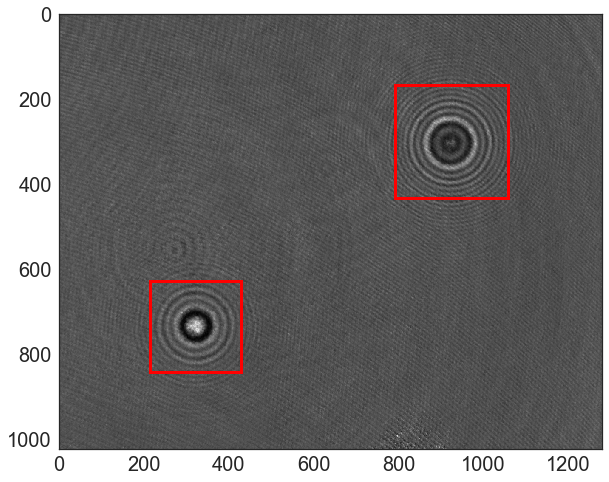

In [21]:
# Re-plot with improved bounding box.
fig, ax = plt.subplots()
ax.imshow(norm, cmap='gray')
for feature in features:
    x, y, w, h = feature
    test_rect = Rectangle(xy=(x - w/2, y - h/2), width=w, height=h, fill=False, linewidth=3, edgecolor='r')
    ax.add_patch(test_rect)

In [22]:
# We will repeat the same procedure with CNNLorenzMie
localizer.threshold = .4
feats = localizer.predict([inflate(norm)*100]) #NOTE: Localizer expects images with a mean ~100.

In [23]:
# Run through filter to eliminate duplicate predictions for good measure
feats = nodoubles(feats, tol=20)

In [24]:
feats

[[{'label': b'HOLO',
   'conf': 0.7124173045158386,
   'bbox': (921.7688598632812,
    302.83734130859375,
    93.31919860839844,
    90.13401794433594)},
  {'label': b'HOLO',
   'conf': 0.654472827911377,
   'bbox': (278.26837158203125,
    550.3216552734375,
    82.5567626953125,
    88.80533599853516)},
  {'label': b'HOLO',
   'conf': 0.49716445803642273,
   'bbox': (322.886962890625,
    732.1749267578125,
    97.04308319091797,
    92.4044418334961)}]]

In [25]:
# Manipulate data to a matrix with columns [xc, yc, w, h] and rows as the features. Change default bounding box again.
features = []
bboxs = []
for feature in feats[0]:
    xc, yc, w, h = feature['bbox']
    s = localize.feature_extent(norm, (xc, yc),
                       nfringes=28)
    features.append([xc, yc, s, s])

In [26]:
features

[[921.7688598632812, 302.83734130859375, 220.0, 220.0],
 [278.26837158203125, 550.3216552734375, 399.0, 399.0],
 [322.886962890625, 732.1749267578125, 214.0, 214.0]]

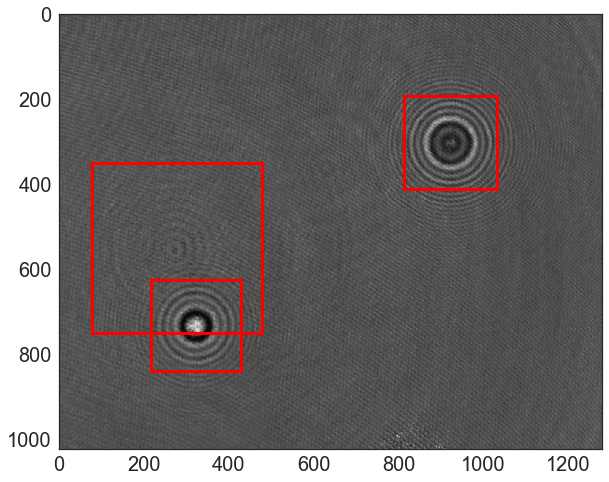

In [27]:
# Plot results
fig, ax = plt.subplots()
ax.imshow(norm, cmap='gray')
for feature in features:
    x, y, w, h = feature
    test_rect = Rectangle(xy=(x - w/2, y - h/2), width=w, height=h, fill=False, linewidth=3, edgecolor='r')
    ax.add_patch(test_rect)

Notice the false positive detection. The localizer has even picked up the circular structure in an artifact of our microscope!

## Fit the frame.
Crop to the relevant region, then use Feature.py to fit the image.

In [28]:
# Crop the frame to a reasonable size for fitting. Pick one of the features to fit.
xc, yc, w, h = features[2]
xc, yc, w, h = int(xc), int(yc), int(w), int(h)
cropped_norm = norm[yc-h//2:yc+h//2, xc-w//2:xc+w//2]

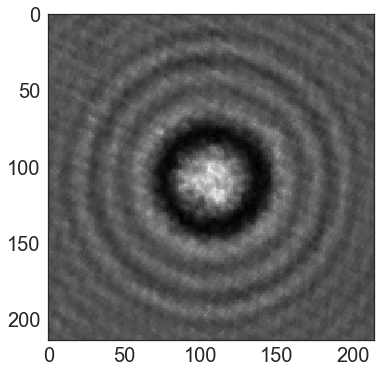

In [29]:
# Check the crop.
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(cropped_norm, cmap='gray', interpolation=None)

In [30]:
# Initialize guesses for fitting and Instrument
shape = cropped_norm.shape
guesses = {'a_p': .92, #um
           'n_p': 1.41,
           'r_p': [shape[0] // 2, shape[1] // 2, 200.]} #pixels
instrument = Instrument.Instrument(wavelength=.447,    #pixels
                                   magnification=.048, #microns/pixel
                                   n_m=1.340,
                                   dark_count=13,
                                   background=1.)

In [31]:
# Initialize fitter
fitter = Feature(**guesses)
fitter.model.instrument = instrument
fitter.model.coordinates = Instrument.coordinates(shape)
fitter.data = (cropped_norm).reshape(cropped_norm.size)

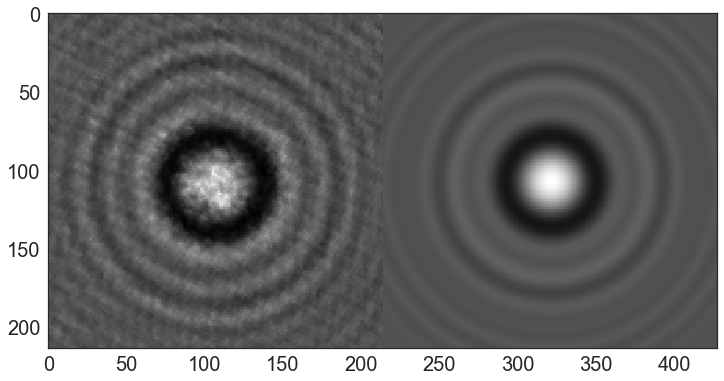

In [32]:
# Plot initial guesses vs. experimental image
guess = fitter.model.hologram().reshape(shape)
feature = fitter.data.reshape(shape)
plt.imshow(np.hstack([feature, guess]),
           cmap='gray')

In [33]:
# Fit
result = fitter.optimize()
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 67
    # data points      = 45796
    # variables        = 5
    chi-square         = 222087.638
    reduced chi-square = 4.85002813
    Akaike info crit   = 72316.1741
    Bayesian info crit = 72359.8339
[[Variables]]
    x_p:  106.779805 +/- 0.01809827 (0.02%) (init = 107)
    y_p:  108.513875 +/- 0.01779305 (0.02%) (init = 107)
    z_p:  229.359946 +/- 0.13437788 (0.06%) (init = 200)
    a_p:  0.85832635 +/- 9.0897e-04 (0.11%) (init = 0.92)
    n_p:  1.44278939 +/- 2.1989e-04 (0.02%) (init = 1.41)
    k_p:  0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(z_p, a_p) =  0.627
    C(a_p, n_p) = -0.251
    C(z_p, n_p) =  0.208


## Show the result side-by-side.

In [34]:
# Prepare residuals and fitted image for plotting
residual = result.residual.reshape(shape)
fit = fitter.model.hologram().reshape(shape)

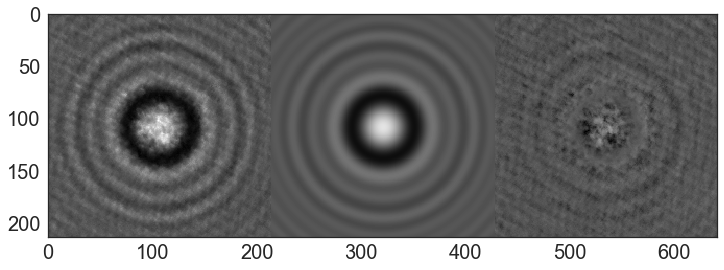

In [35]:
# Plot cropped image vs fitted image vs residuals
noise = fitter.noise
mega_image = np.hstack([cropped_norm,
                        fit,
                        residual*fitter.noise+1.0])
fig, ax = plt.subplots(figsize=(12, 36))
ax.imshow(mega_image, cmap='gray', interpolation=None)